In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from lrcurve import KerasLearningCurve
import matplotlib.pyplot as plt
#%matplotlib inline
from IPython.display import clear_output
from livelossplot import PlotLossesKeras, PlotLossesKerasTF

from keras import models, layers, callbacks, optimizers, regularizers

np.random.seed(1)  # pick seed for reproducible article images


In [32]:
def load_rent(n:int=None):
    """
    Download train.json from https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data
    and save into data subdir.
    """
    # df = pd.read_json(f'train.json')
    df = pd.read_csv('../articles/pd/rent10k.csv')
    print(f"Rent has {len(df)} records")

    if n is not None:
        df = df.sample(n)
        
    X = df.drop('price', axis=1)
    y = df['price']
    return X, y


# X_raw, y_raw = load_rent(n=5_000)
X_raw, y_raw = load_rent()

X, y = X_raw.copy(), y_raw.copy()

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
# y = (y - np.mean(y))/np.std(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

Rent has 10000 records


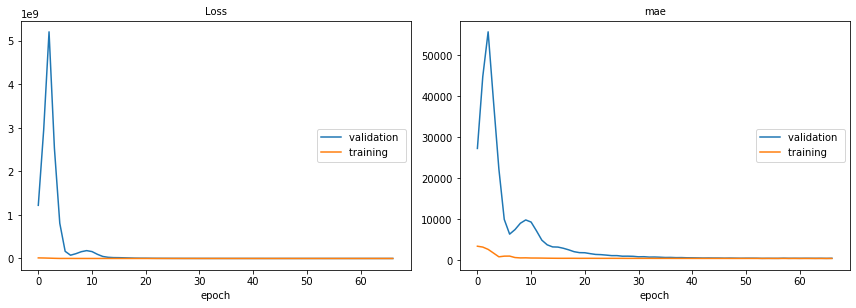

Loss
	validation       	 (min: 472462.688, max: 20051628032.000, cur: 506843.312)
	training         	 (min: 364876.969, max: 14328903.000, cur: 408671.352)
mae
	validation       	 (min:  448.963, max: 119121.125, cur:  479.954)
	training         	 (min:  419.023, max: 3506.250, cur:  441.018)


KeyboardInterrupt: 

In [49]:
model = models.Sequential()
layer1 = 1400
layer2 = 1400
layer3 = 1400
batch_size = 2000
dropout = 0.4
l1_penalty = 0.0
l2_penalty = 0.000001
model.add(layers.Dense(layer1, input_dim=X.shape[1], activation='relu', activity_regularizer=regularizers.l1_l2(l2_penalty,l1_penalty)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(layer2, activation='relu', activity_regularizer=regularizers.l1_l2(l2_penalty,l1_penalty)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(layer3, activation='relu', activity_regularizer=regularizers.l1_l2(l2_penalty,l1_penalty)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(1))

#learning_rate=1e-2 #DEFAULT
# SGB gets NaNs?
#opt = optimizers.SGD(lr=0.01)
opt = optimizers.Adam(lr=0.1)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
# model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mae'])
# model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['mae'])

fconfig = {
#    'loss': { 'name': 'loss', 'limit': [0, 1] },
    'mae': { 'name': 'mae', 'limit': [0, 800] }
}
metric_mapping = {
                    'loss': { 'facet': 'loss', 'line': 'train' },
                    'val_loss': { 'facet': 'loss', 'line': 'validation' },
               }
callback = callbacks.EarlyStopping(monitor='val_loss', patience=40)

history = model.fit(X_train, y_train,
                    #epochs=1000,
                    epochs=100,
#                    validation_split=0.2,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    #callbacks=[callback],
#                    callbacks=[KerasLearningCurve(facet_config=config, metric_mapping=metric_mapping)],
                    callbacks=[PlotLossesKerasTF()],
                    verbose=0
                    )

In [47]:
y_pred = model.predict(X_train)
# y_pred *= np.std(y_raw)  # undo normalization on y
# y_pred += np.mean(y_raw)
r2 = r2_score(y_train, y_pred)
print("Keras training R^2", r2)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Keras validation R^2", r2)

Keras training R^2 0.7136300984918421
Keras validation R^2 0.662901671937224


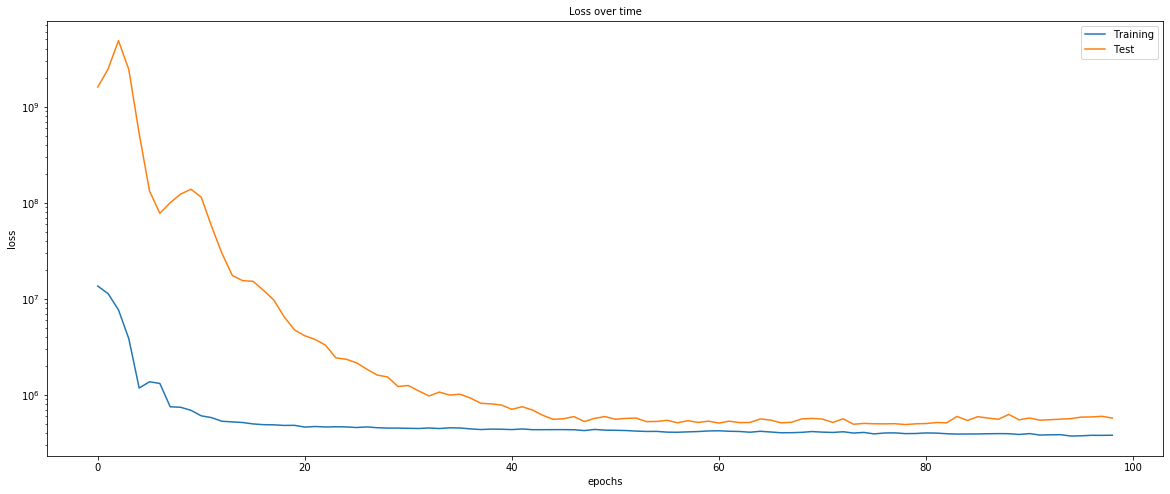

In [48]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);